In [ ]:
!ls '/content/drive/MyDrive/Colab Notebooks/IA/bcc/tutorial_deep_learning/datasetBrain/CroppedTesting'

no_tumor  yes_tumor


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
INIT_LR = 1e-4 #tamanho to passo 
EPOCHS = 3
BS = 32 

In [ ]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/IA/bcc/tutorial_deep_learning/datasetBrain/CroppedTraining/'
CATEGORIES = ['no_tumor','yes_tumor']

In [ ]:
data = [] #imagens
labels = [] #classe.

In [ ]:
for category in CATEGORIES:
    path = os.path.join(train_dir, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224,224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [ ]:
aug = ImageDataGenerator(
    rotation_range=20, #
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
for layer in baseModel.layers:
	  layer.trainable = False

# compile our model
# print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/3
39/39 [==============================] - 54s 1s/step - loss: 0.4037 - accuracy: 0.8710 - val_loss: 0.2951 - val_accuracy: 0.9137
Epoch 2/3
39/39 [==============================] - 49s 1s/step - loss: 0.3118 - accuracy: 0.9145 - val_loss: 0.2729 - val_accuracy: 0.9137
Epoch 3/3
39/39 [==============================] - 49s 1s/step - loss: 0.2807 - accuracy: 0.9129 - val_loss: 0.2606 - val_accuracy: 0.9137


In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk, can be a drive path.
print("[INFO] saving covid detector model...")
model.save("tumor_detector.model", save_format="h5")

[INFO] evaluating network...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    no_tumor       0.91      1.00      0.95       286
   yes_tumor       0.00      0.00      0.00        27

    accuracy                           0.91       313
   macro avg       0.46      0.50      0.48       313
weighted avg       0.83      0.91      0.87       313

[INFO] saving covid detector model...


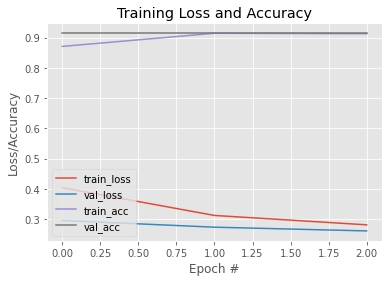

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf
import argparse
import imutils
import time
import cv2

In [ ]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[INFO] loading trained model for tumor classification...


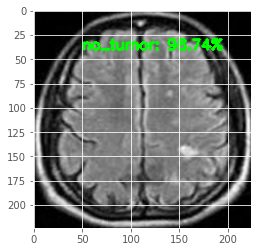

In [ ]:
print("[INFO] loading trained model for tumor classification...")
model = tf.keras.models.load_model('tumor_detector.model')
image = cv2.imread("//content/drive/MyDrive/Colab Notebooks/IA/bcc/tutorial_deep_learning/datasetBrain/CroppedTesting/no_tumor/0.jpg")
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
img = img_to_array(img)
img = preprocess_input(img)
img = np.expand_dims(img, axis=0)
(no_tumor,yes_tumor) = model.predict(img)[0]
label = "no_tumor" if no_tumor > yes_tumor else "yes Tumor"
color = (0, 255, 0) if label == "no_tumor" else (0, 0, 255)
label = "{}: {:.2f}%".format(label, max(no_tumor, yes_tumor) * 100)
cv2.putText(image, label, (50, 50 - 10),
cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()